# Demo: Training BERT using TensorFlow and Keras

This notebook demonstrate how to fine-tune a small BERT model using TensorFlow and Keras. The model will be trained on a text dataset to classify text into either positive or negative labels.

Note that training BERT models can be computationally intensive, so using a GPU is highly recommended.

**References**:
- [Classify text with BERT](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)

## Set Up Environment

### Install required packages

In [ ]:
!pip install tensorflow==2.16.1 keras==3.1.1 keras-nlp==0.8.2

## Import Packages and Define Global Variables

In [ ]:
import os

import keras
import keras_nlp
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

os.environ['KERAS_BACKEND'] = 'tensorflow'

In [ ]:
IS_TRAIN = True
MIXED_PRECISION = True      # Use mixed precision for training.
DETERMINISM = True          # Run in deterministic mode.
FREEZE_BACKBONE = False
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42
BATCH_SIZE = 32
TRAIN_DATA_RATIO = 80       # in %
TRAIN_EPOCHS = 10
LEARNING_RATE = 5e-5

In [ ]:
if MIXED_PRECISION:
    keras.mixed_precision.set_global_policy('mixed_float16')

if DETERMINISM:
    keras.utils.set_random_seed(SEED)

## Prepare Data

[Large Movie Review Dataset](https://www.tensorflow.org/datasets/catalog/imdb_reviews). This is a dataset for binary sentiment classification and provides a set of 25,000 movie reviews for training, and 25,000 for testing.

In [ ]:
train_ds, val_ds, test_ds = tfds.load(
    name='imdb_reviews',
    split=(f'train[:{TRAIN_DATA_RATIO}%]',
           f'train[{TRAIN_DATA_RATIO}%:]', 'test'),
    as_supervised=True
)

In [ ]:
print('Show samples in dataset:')
for i, (data_batch, label_batch) in enumerate(train_ds.take(4)):
    print(f'Sample #{i + 1}')
    print(f'    text: {data_batch.numpy()}')
    print(f'    label: {label_batch.numpy()}')

Show samples in dataset:
Sample #1
    text: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
    label: 0
Sample #2
    text: b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this

In [ ]:
train_ds = train_ds.shuffle(2048, seed=SEED)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.cache().prefetch(AUTOTUNE)

val_ds = val_ds.batch(BATCH_SIZE * 4)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

## Define Model

In [ ]:
model = keras_nlp.models.BertClassifier.from_preset(
    'bert_small_en_uncased',
    num_classes=1
)

if FREEZE_BACKBONE:
    model.backbone.trainable = False

model.summary()

Preprocessor: "bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 512), (None,      │      28,763,648 │ padding_mask[0][0],        │
│                               │ None, 512)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 512)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 1)                 │             513 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 28,764,161 (109.73 MB)

 Trainable params: 28,764,161 (109.73 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [ ]:
history = None
if IS_TRAIN:
    model.compile(
        optimizer=keras.optimizers.AdamW(LEARNING_RATE),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    early_stop_callback = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)
    history = model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=TRAIN_EPOCHS,
                        verbose=1,
                        callbacks=[early_stop_callback])

    model.save_weights(f'/content/final.weights.h5')

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 188s 199ms/step - accuracy: 0.8009 - loss: 0.3932 - val_accuracy: 0.9016 - val_loss: 0.2431
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 167s 266ms/step - accuracy: 0.9203 - loss: 0.2020 - val_accuracy: 0.9076 - val_loss: 0.2843
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 164s 263ms/step - accuracy: 0.9493 - loss: 0.1349 - val_accuracy: 0.9068 - val_loss: 0.2610


### Visualize Training Process

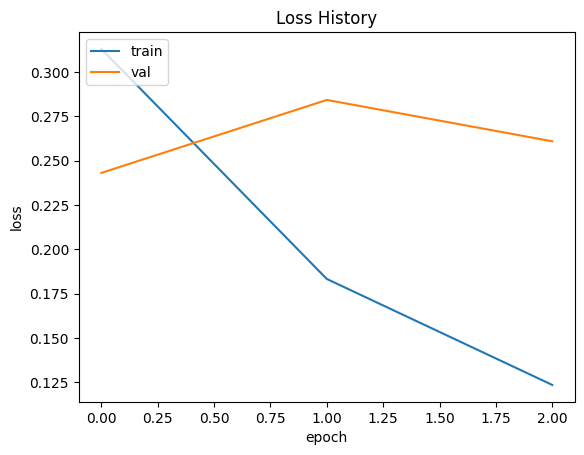

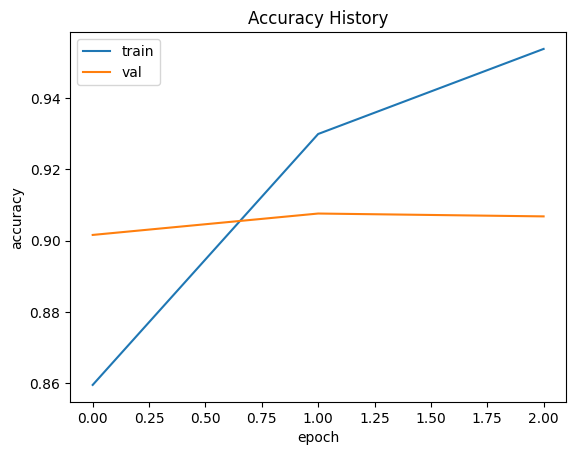

In [ ]:
if history is not None:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss History')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy History')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()